# Credit Card Fraud Detection using Random Forest (Anomaly Detection)

이 노트북은 신용 카드 사기 탐지를 위한 랜덤 포레스트(Random Forest) 기반 이상치 탐지 모델을 구현합니다. 
정상 거래 데이터만을 사용하여 모델을 학습하고, 사기 거래를 이상치로 탐지하는 접근 방식을 사용합니다.

## 접근 방법

이 구현에서는 다음과 같은 anomaly detection 접근법을 사용합니다:

1. **정상 데이터만으로 학습**: 사기 거래(레이블 1)를 제외하고 정상 거래(레이블 0)만으로 모델을 학습합니다.
2. **특성 재구성**: Random Forest를 사용하여 정상 데이터의 패턴을 학습하고 특성을 재구성합니다.
3. **이상치 점수 계산**: 재구성 오차나 예측 확률을 기반으로 이상치 점수를 계산합니다.
4. **임계값 기반 탐지**: 계산된 점수가 임계값을 초과하는 경우 사기 거래로 분류합니다.

이러한 접근 방식은 레이블이 없는 상황이나 정상 데이터가 압도적으로 많은 불균형 데이터셋에서 효과적입니다.

In [1]:
# Core libraries for data processing and machine learning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                            recall_score, f1_score, roc_auc_score, roc_curve)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import time
import warnings

# 불필요한 경고 무시
warnings.filterwarnings("ignore")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# ==========================================
# Data Loading and Preprocessing Pipeline for Anomaly Detection
# ==========================================

# Load preprocessed credit card fraud dataset
df = pd.read_csv("preprocessed-creditcard.csv")
X = df.drop("Class", axis=1).values  # Feature matrix
y = df["Class"].values                # Target labels (0: normal, 1: fraud)

print(f"Dataset loaded: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Fraud rate: {np.mean(y):.4f} ({np.sum(y)} fraud cases)")

# Separate normal and fraud data
normal_mask = (y == 0)
fraud_mask = (y == 1)

X_normal = X[normal_mask]
X_fraud = X[fraud_mask]
y_normal = y[normal_mask]
y_fraud = y[fraud_mask]

print(f"Normal transactions: {len(X_normal)}")
print(f"Fraudulent transactions: {len(X_fraud)}")

# Split normal data into train and validation sets (80-20 split)
# We'll use only normal data for training
X_normal_train, X_normal_val = train_test_split(
    X_normal, test_size=0.2, random_state=42
)

# Create test set with both normal validation data and all fraud data
X_test = np.vstack([X_normal_val, X_fraud])
y_test = np.hstack([np.zeros(len(X_normal_val)), np.ones(len(X_fraud))])

# Feature standardization using Z-score normalization
# Fit scaler only on normal training data
scaler = StandardScaler()
X_normal_train_scaled = scaler.fit_transform(X_normal_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set (normal only): {X_normal_train_scaled.shape}")
print(f"Test set (normal + fraud): {X_test_scaled.shape}")
print(f"Test set fraud rate: {np.mean(y_test):.4f}")

Dataset loaded: 946 samples, 30 features
Fraud rate: 0.5000 (473 fraud cases)
Normal transactions: 473
Fraudulent transactions: 473

Training set (normal only): (378, 30)
Test set (normal + fraud): (568, 30)
Test set fraud rate: 0.8327


In [3]:
# ==========================================
# Configuration for Anomaly Detection
# ==========================================

# TRAINING CONFIGURATION
TRAINING_CONFIG = {
    'n_estimators': 100,          # Number of trees in the forest
    'max_depth': 10,              # Maximum depth of the tree
    'min_samples_split': 2,       # Minimum samples required to split a node
    'min_samples_leaf': 1,        # Minimum samples required at a leaf node
    'bootstrap': True,            # Whether bootstrap samples are used
    'criterion': 'squared_error', # For regression to get continuous scores
    'random_state': 42,           # Seed for reproducibility
    'n_jobs': -1                  # Use all available cores
}

# ANOMALY DETECTION CONFIGURATION
ANOMALY_CONFIG = {
    'contamination_rate': 0.1,    # Expected fraction of anomalies in test set
    'distance_metric': 'euclidean',  # Distance metric for anomaly scoring
    'use_leaf_distance': True     # Use leaf node distances for scoring
}

print(f"\nTraining Configuration: {TRAINING_CONFIG}")
print(f"Anomaly Detection Configuration: {ANOMALY_CONFIG}")
print("="*80)


Training Configuration: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'criterion': 'squared_error', 'random_state': 42, 'n_jobs': -1}
Anomaly Detection Configuration: {'contamination_rate': 0.1, 'distance_metric': 'euclidean', 'use_leaf_distance': True}


In [4]:
def train_random_forest_anomaly_detector(X_normal, config):
    """
    정상 데이터만으로 랜덤 포레스트 기반 이상치 탐지 모델 학습 함수
    
    Args:
        X_normal: 정상 데이터 (사기 거래 제외)
        config: 모델 설정 파라미터
        
    Returns:
        dict: 학습된 모델과 관련 정보
    """
    print(f"\n{'='*60}")
    print("TRAINING: RANDOM FOREST ANOMALY DETECTOR")
    print(f"{'='*60}")
    
    # 훈련 시작 시간 기록
    start_time = time.time()
    
    # Random Forest Regressor for anomaly detection
    # We'll use regression to predict each feature using others
    from sklearn.ensemble import RandomForestRegressor
    
    # 각 특성을 예측하는 모델들을 저장할 리스트
    feature_models = []
    
    n_features = X_normal.shape[1]
    
    print(f"Training {n_features} Random Forest models (one per feature)...")
    
    # 각 특성에 대해 별도의 Random Forest 모델 학습
    for i in range(n_features):
        if i % 5 == 0:  # 진행 상황 출력
            print(f"  Training model for feature {i+1}/{n_features}")
        
        # i번째 특성을 제외한 나머지 특성들로 i번째 특성 예측
        X_train_feature = np.delete(X_normal, i, axis=1)  # i번째 열 제거
        y_train_feature = X_normal[:, i]  # i번째 특성을 타겟으로
        
        # Random Forest Regressor 생성 및 학습
        rf_model = RandomForestRegressor(
            n_estimators=config['n_estimators'],
            max_depth=config['max_depth'],
            min_samples_split=config['min_samples_split'],
            min_samples_leaf=config['min_samples_leaf'],
            bootstrap=config['bootstrap'],
            criterion=config['criterion'],
            random_state=config['random_state'] + i,  # 각 모델마다 다른 시드
            n_jobs=1,  # 메모리 사용량 제어
            verbose=0
        )
        
        rf_model.fit(X_train_feature, y_train_feature)
        feature_models.append(rf_model)
    
    # 훈련 종료 시간과 소요 시간 계산
    training_time = time.time() - start_time
    print(f"\nTraining completed in {training_time:.2f} seconds")
    
    return {
        'feature_models': feature_models,
        'n_features': n_features,
        'training_time': training_time,
        'training_data_stats': {
            'mean': np.mean(X_normal, axis=0),
            'std': np.std(X_normal, axis=0),
            'min': np.min(X_normal, axis=0),
            'max': np.max(X_normal, axis=0)
        }
    }

def calculate_anomaly_scores(models_info, X_test):
    """
    테스트 데이터에 대해 이상치 점수 계산
    
    Args:
        models_info: 학습된 모델 정보
        X_test: 테스트 데이터
        
    Returns:
        numpy.array: 각 샘플의 이상치 점수
    """
    feature_models = models_info['feature_models']
    n_features = models_info['n_features']
    
    # 각 샘플에 대한 재구성 오차 계산
    reconstruction_errors = []
    
    print("Calculating anomaly scores...")
    
    for i in range(n_features):
        # i번째 특성을 제외한 나머지 특성들로 i번째 특성 예측
        X_test_feature = np.delete(X_test, i, axis=1)
        y_true_feature = X_test[:, i]
        
        # 예측
        y_pred_feature = feature_models[i].predict(X_test_feature)
        
        # 재구성 오차 (실제값과 예측값의 차이)
        feature_error = np.abs(y_true_feature - y_pred_feature)
        reconstruction_errors.append(feature_error)
    
    # 모든 특성의 재구성 오차를 합하여 최종 이상치 점수 계산
    reconstruction_errors = np.array(reconstruction_errors).T  # (n_samples, n_features)
    anomaly_scores = np.mean(reconstruction_errors, axis=1)  # 평균 재구성 오차
    
    return anomaly_scores

In [5]:
# 모델 학습 (정상 데이터만 사용)
results = {}
try:
    rf_result = train_random_forest_anomaly_detector(X_normal_train_scaled, TRAINING_CONFIG)
    results['rf_anomaly'] = rf_result
    print("Random Forest anomaly detection model completed successfully")
    
    # 이상치 점수 계산
    print("\nCalculating anomaly scores for test data...")
    anomaly_scores = calculate_anomaly_scores(rf_result, X_test_scaled)
    results['rf_anomaly']['anomaly_scores'] = anomaly_scores
    
    print(f"Anomaly scores calculated for {len(anomaly_scores)} test samples")
    print(f"Score range: {np.min(anomaly_scores):.4f} - {np.max(anomaly_scores):.4f}")
    
except Exception as e:
    print(f"Random Forest anomaly detection model failed: {str(e)}")
    results['rf_anomaly'] = {'error': str(e)}


TRAINING: RANDOM FOREST ANOMALY DETECTOR
Training 30 Random Forest models (one per feature)...
  Training model for feature 1/30
  Training model for feature 6/30
  Training model for feature 6/30
  Training model for feature 11/30
  Training model for feature 11/30
  Training model for feature 16/30
  Training model for feature 16/30
  Training model for feature 21/30
  Training model for feature 21/30
  Training model for feature 26/30
  Training model for feature 26/30

Training completed in 37.63 seconds
Random Forest anomaly detection model completed successfully

Calculating anomaly scores for test data...
Calculating anomaly scores...

Training completed in 37.63 seconds
Random Forest anomaly detection model completed successfully

Calculating anomaly scores for test data...
Calculating anomaly scores...
Anomaly scores calculated for 568 test samples
Score range: 0.1496 - 10.7848
Anomaly scores calculated for 568 test samples
Score range: 0.1496 - 10.7848


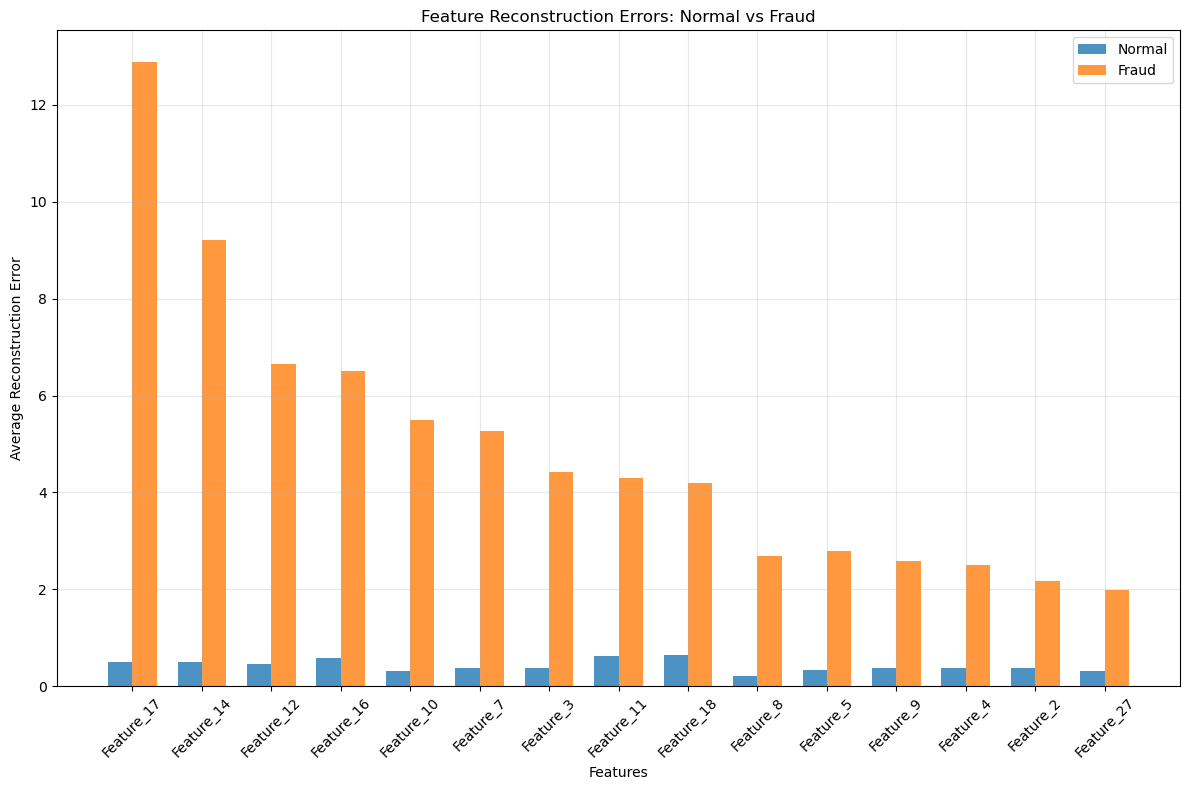


Top 10 features for fraud discrimination:
   1. Feature_17: Normal=0.4888, Fraud=12.8961, Diff=12.4073
   2. Feature_14: Normal=0.4991, Fraud=9.2020, Diff=8.7030
   3. Feature_12: Normal=0.4639, Fraud=6.6419, Diff=6.1780
   4. Feature_16: Normal=0.5809, Fraud=6.5079, Diff=5.9270
   5. Feature_10: Normal=0.3053, Fraud=5.4893, Diff=5.1840
   6. Feature_7: Normal=0.3729, Fraud=5.2670, Diff=4.8941
   7. Feature_3: Normal=0.3706, Fraud=4.4306, Diff=4.0601
   8. Feature_11: Normal=0.6269, Fraud=4.2889, Diff=3.6619
   9. Feature_18: Normal=0.6345, Fraud=4.1848, Diff=3.5503
  10. Feature_8: Normal=0.2159, Fraud=2.6805, Diff=2.4647


In [6]:
# 특성별 재구성 오차 분석
def analyze_feature_reconstruction_errors(models_info, X_test, y_test, top_n=15):
    """
    각 특성별 재구성 오차를 분석하고 시각화하는 함수
    
    Args:
        models_info: 학습된 모델 정보
        X_test: 테스트 데이터
        y_test: 테스트 레이블
        top_n: 표시할 상위 특성 수
    """
    feature_models = models_info['feature_models']
    n_features = models_info['n_features']
    
    # 정상/사기 데이터별 특성별 재구성 오차 계산
    normal_mask = (y_test == 0)
    fraud_mask = (y_test == 1)
    
    feature_errors_normal = []
    feature_errors_fraud = []
    
    for i in range(n_features):
        X_test_feature = np.delete(X_test, i, axis=1)
        y_true_feature = X_test[:, i]
        y_pred_feature = feature_models[i].predict(X_test_feature)
        
        feature_error = np.abs(y_true_feature - y_pred_feature)
        
        # 정상/사기별 평균 오차
        normal_error = np.mean(feature_error[normal_mask]) if np.any(normal_mask) else 0
        fraud_error = np.mean(feature_error[fraud_mask]) if np.any(fraud_mask) else 0
        
        feature_errors_normal.append(normal_error)
        feature_errors_fraud.append(fraud_error)
    
    # 사기 탐지에 유용한 특성 찾기 (사기 데이터에서 오차가 큰 특성)
    discrimination_scores = np.array(feature_errors_fraud) - np.array(feature_errors_normal)
    top_indices = np.argsort(discrimination_scores)[::-1][:top_n]
    
    # 시각화
    plt.figure(figsize=(12, 8))
    
    # 상위 특성들의 오차 비교
    x_pos = np.arange(len(top_indices))
    width = 0.35
    
    normal_errors = [feature_errors_normal[i] for i in top_indices]
    fraud_errors = [feature_errors_fraud[i] for i in top_indices]
    feature_names = [f"Feature_{i}" for i in top_indices]
    
    plt.bar(x_pos - width/2, normal_errors, width, label='Normal', alpha=0.8)
    plt.bar(x_pos + width/2, fraud_errors, width, label='Fraud', alpha=0.8)
    
    plt.xlabel('Features')
    plt.ylabel('Average Reconstruction Error')
    plt.title('Feature Reconstruction Errors: Normal vs Fraud')
    plt.xticks(x_pos, feature_names, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 상위 10개 특성 정보 출력
    print("\nTop 10 features for fraud discrimination:")
    for i, idx in enumerate(top_indices[:10]):
        print(f"  {i+1:2d}. Feature_{idx}: Normal={feature_errors_normal[idx]:.4f}, "
              f"Fraud={feature_errors_fraud[idx]:.4f}, "
              f"Diff={discrimination_scores[idx]:.4f}")

# 특성별 재구성 오차 분석 (학습이 성공적으로 완료된 경우)
if 'error' not in results['rf_anomaly']:
    analyze_feature_reconstruction_errors(results['rf_anomaly'], X_test_scaled, y_test)

In [7]:
# 이상치 탐지 모델 평가
def evaluate_anomaly_detection_model(anomaly_scores, y_test):
    """
    이상치 탐지 모델 평가 함수
    
    Args:
        anomaly_scores: 각 샘플의 이상치 점수
        y_test: 테스트 레이블 (0: normal, 1: fraud)
        
    Returns:
        dict: 평가 지표들을 포함한 딕셔너리
    """
    # 다양한 백분위수를 임계값으로 사용하여 성능 평가
    percentiles = [50, 60, 70, 80, 85, 90, 95, 97, 99]
    results = []
    
    print("Threshold optimization (using percentiles of anomaly scores):")
    
    for percentile in percentiles:
        threshold = np.percentile(anomaly_scores, percentile)
        y_pred = (anomaly_scores >= threshold).astype(int)
        
        # 혼동 행렬 계산
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
        
        # 평가 지표 계산
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        spec = tn / (tn + fp) if (tn + fp) else 0.0
        gmean = (rec * spec) ** 0.5
        
        results.append({
            'percentile': percentile,
            'threshold': threshold,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'specificity': spec,
            'gmean': gmean,
            'confusion_matrix': {
                'tn': int(tn),
                'fp': int(fp),
                'fn': int(fn),
                'tp': int(tp)
            }
        })
        
        print(f"  P={percentile:2d}% (T={threshold:.4f}): Acc={acc:.3f} Prec={prec:.3f} "
              f"Rec={rec:.3f} F1={f1:.3f} G-Mean={gmean:.3f}")
    
    # AUC-ROC 점수 계산 (높은 점수가 이상치이므로 그대로 사용)
    auc = roc_auc_score(y_test, anomaly_scores)
    
    # G-Mean 기준으로 최적의 임계값 찾기
    best_result = max(results, key=lambda x: x['gmean'])
    
    print("\nRESULTS SUMMARY:")
    print(f"  AUC-ROC Score: {auc:.4f}")
    print(f"  Best Threshold: {best_result['percentile']}th percentile "
          f"({best_result['threshold']:.4f}) (G-Mean: {best_result['gmean']:.3f})")
    print(f"  Best Performance: Acc={best_result['accuracy']:.3f}, "
          f"Prec={best_result['precision']:.3f}, Rec={best_result['recall']:.3f}, "
          f"F1={best_result['f1_score']:.3f}")
    
    # 최적의 임계값에서의 혼동 행렬
    cm = best_result['confusion_matrix']
    print(f"\nConfusion Matrix at {best_result['percentile']}th percentile:")
    print(f"  True Negative: {cm['tn']}, False Positive: {cm['fp']}")
    print(f"  False Negative: {cm['fn']}, True Positive: {cm['tp']}")
    
    # 이상치 점수 분포 분석
    normal_scores = anomaly_scores[y_test == 0]
    fraud_scores = anomaly_scores[y_test == 1]
    
    print(f"\nAnomaly Score Distribution:")
    print(f"  Normal - Mean: {np.mean(normal_scores):.4f}, Std: {np.std(normal_scores):.4f}")
    print(f"  Fraud  - Mean: {np.mean(fraud_scores):.4f}, Std: {np.std(fraud_scores):.4f}")
    
    return {
        'auc': auc,
        'best_threshold_percentile': best_result['percentile'],
        'best_threshold': best_result['threshold'],
        'best_metrics': best_result,
        'all_results': results,
        'score_stats': {
            'normal_mean': np.mean(normal_scores),
            'normal_std': np.std(normal_scores),
            'fraud_mean': np.mean(fraud_scores),
            'fraud_std': np.std(fraud_scores)
        }
    }

# 모델 평가 (학습이 성공적으로 완료된 경우)
if 'error' not in results['rf_anomaly'] and 'anomaly_scores' in results['rf_anomaly']:
    eval_results = evaluate_anomaly_detection_model(
        results['rf_anomaly']['anomaly_scores'], y_test
    )
    results['rf_anomaly']['evaluation'] = eval_results

Threshold optimization (using percentiles of anomaly scores):
  P=50% (T=2.2436): Acc=0.664 Prec=0.996 Rec=0.598 F1=0.748 G-Mean=0.769
  P=60% (T=2.6842): Acc=0.567 Prec=1.000 Rec=0.480 F1=0.649 G-Mean=0.693
  P=70% (T=3.1435): Acc=0.468 Prec=1.000 Rec=0.362 F1=0.531 G-Mean=0.601
  P=80% (T=3.9076): Acc=0.368 Prec=1.000 Rec=0.241 F1=0.388 G-Mean=0.491
  P=85% (T=6.1187): Acc=0.319 Prec=1.000 Rec=0.182 F1=0.308 G-Mean=0.426
  P=90% (T=6.3212): Acc=0.268 Prec=1.000 Rec=0.121 F1=0.215 G-Mean=0.347
  P=95% (T=6.4445): Acc=0.218 Prec=1.000 Rec=0.061 F1=0.116 G-Mean=0.248
  P=97% (T=6.5652): Acc=0.199 Prec=1.000 Rec=0.038 F1=0.073 G-Mean=0.195
  P=99% (T=7.8746): Acc=0.178 Prec=1.000 Rec=0.013 F1=0.025 G-Mean=0.113

RESULTS SUMMARY:
  AUC-ROC Score: 0.9482
  Best Threshold: 50th percentile (2.2436) (G-Mean: 0.769)
  Best Performance: Acc=0.664, Prec=0.996, Rec=0.598, F1=0.748

Confusion Matrix at 50th percentile:
  True Negative: 94, False Positive: 1
  False Negative: 190, True Positive: 28

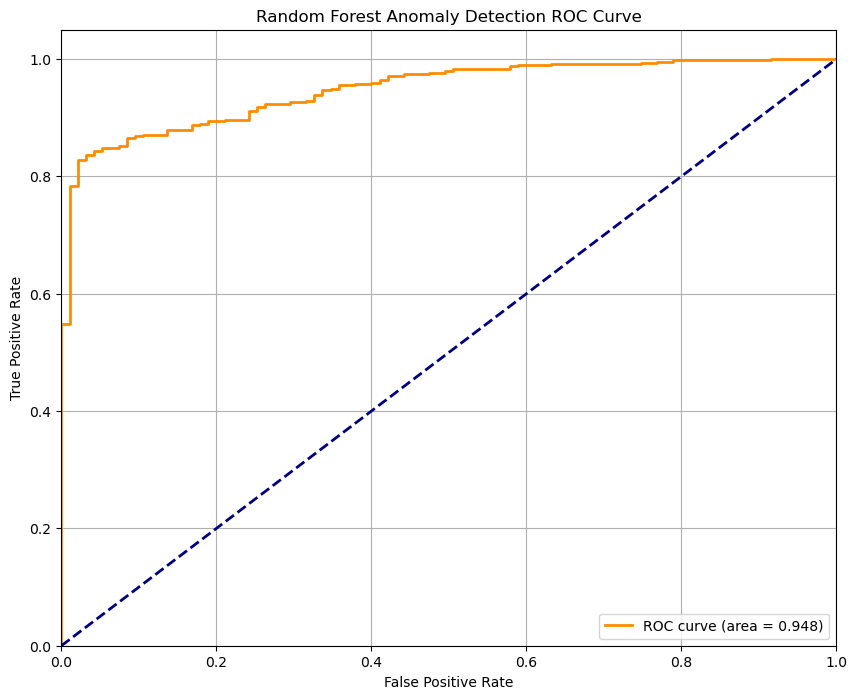

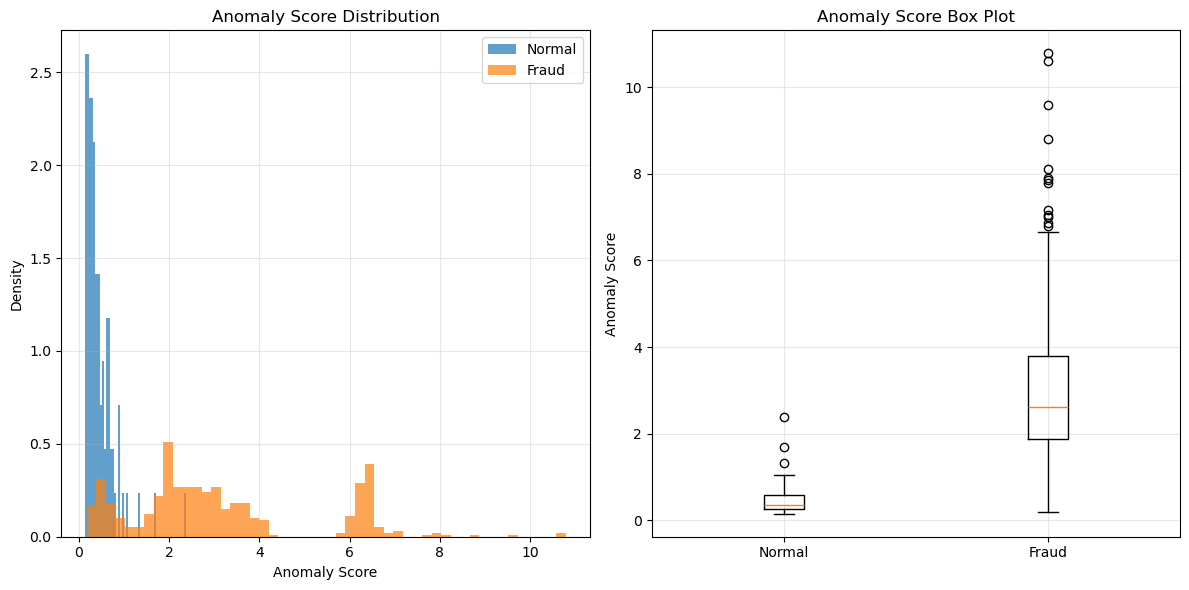

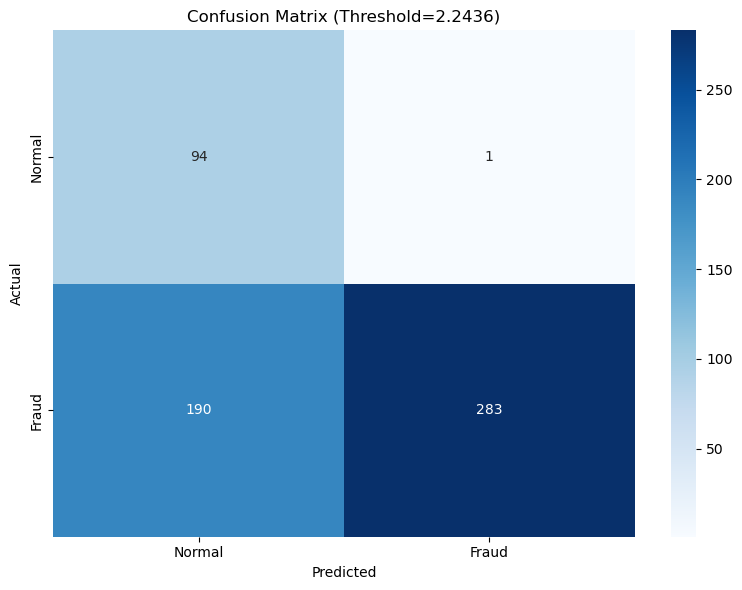

In [8]:
# 이상치 탐지 결과 시각화
def plot_anomaly_detection_roc_curve(y_test, anomaly_scores, title="Anomaly Detection ROC Curve"):
    """
    이상치 탐지 ROC 곡선을 시각화하는 함수
    
    Args:
        y_test: 실제 레이블
        anomaly_scores: 이상치 점수
        title: 그래프 제목
    """
    fpr, tpr, thresholds = roc_curve(y_test, anomaly_scores)
    roc_auc = roc_auc_score(y_test, anomaly_scores)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def plot_anomaly_score_distribution(anomaly_scores, y_test, title="Anomaly Score Distribution"):
    """
    이상치 점수 분포를 시각화하는 함수
    
    Args:
        anomaly_scores: 이상치 점수
        y_test: 실제 레이블
        title: 그래프 제목
    """
    normal_scores = anomaly_scores[y_test == 0]
    fraud_scores = anomaly_scores[y_test == 1]
    
    plt.figure(figsize=(12, 6))
    
    # 히스토그램
    plt.subplot(1, 2, 1)
    plt.hist(normal_scores, bins=50, alpha=0.7, label='Normal', density=True)
    plt.hist(fraud_scores, bins=50, alpha=0.7, label='Fraud', density=True)
    plt.xlabel('Anomaly Score')
    plt.ylabel('Density')
    plt.title('Anomaly Score Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 박스 플롯
    plt.subplot(1, 2, 2)
    plt.boxplot([normal_scores, fraud_scores], labels=['Normal', 'Fraud'])
    plt.ylabel('Anomaly Score')
    plt.title('Anomaly Score Box Plot')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_anomaly_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix"):
    """
    혼동 행렬을 시각화하는 함수
    
    Args:
        y_true: 실제 레이블
        y_pred: 예측 레이블
        labels: 레이블 이름 리스트
        title: 그래프 제목
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels if labels else ['Normal', 'Fraud'],
                yticklabels=labels if labels else ['Normal', 'Fraud'])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

# 시각화 (학습과 평가가 성공적으로 완료된 경우)
if ('error' not in results['rf_anomaly'] and 
    'anomaly_scores' in results['rf_anomaly'] and 
    'evaluation' in results['rf_anomaly']):
    
    anomaly_scores = results['rf_anomaly']['anomaly_scores']
    evaluation = results['rf_anomaly']['evaluation']
    
    # ROC 곡선
    plot_anomaly_detection_roc_curve(y_test, anomaly_scores, 
                                   title='Random Forest Anomaly Detection ROC Curve')
    
    # 이상치 점수 분포
    plot_anomaly_score_distribution(anomaly_scores, y_test)
    
    # 최적 임계값에서의 혼동 행렬
    best_threshold = evaluation['best_threshold']
    y_pred = (anomaly_scores >= best_threshold).astype(int)
    plot_anomaly_confusion_matrix(y_test, y_pred, 
                                title=f"Confusion Matrix (Threshold={best_threshold:.4f})")

In [9]:
# 이상치 탐지용 하이퍼파라미터 튜닝
def tune_anomaly_detection_hyperparameters(X_normal, X_test, y_test, verbose=True):
    """
    이상치 탐지 모델의 하이퍼파라미터를 최적화하는 함수 
    
    Args:
        X_normal: 정상 데이터 (훈련용)
        X_test: 테스트 데이터
        y_test: 테스트 레이블
        verbose: 상세 출력 여부
        
    Returns:
        dict: 최적의 파라미터와 성능을 포함한 딕셔너리
    """
    print(f"\n{'='*60}") 
    print("HYPERPARAMETER TUNING FOR ANOMALY DETECTION")
    print(f"{'='*60}")
    
    # 튜닝 시작 시간 기록
    start_time = time.time()
    
    # 탐색할 파라미터 그리드 (축소된 버전)
    param_configs = [
        {'n_estimators': 50, 'max_depth': 5},
        {'n_estimators': 50, 'max_depth': 10},
        {'n_estimators': 100, 'max_depth': 5},
        {'n_estimators': 100, 'max_depth': 10},
        {'n_estimators': 100, 'max_depth': 15},
    ]
    
    best_config = None
    best_auc = 0
    best_results = None
    
    for i, config in enumerate(param_configs):
        if verbose:
            print(f"\nTesting configuration {i+1}/{len(param_configs)}: {config}")
        
        try:
            # 현재 설정으로 모델 학습
            training_config = TRAINING_CONFIG.copy()
            training_config.update(config)
            
            # 모델 학습
            model_result = train_random_forest_anomaly_detector(X_normal, training_config)
            
            # 이상치 점수 계산
            anomaly_scores = calculate_anomaly_scores(model_result, X_test)
            
            # AUC 점수 계산
            auc = roc_auc_score(y_test, anomaly_scores)
            
            if verbose:
                print(f"  AUC: {auc:.4f}")
            
            # 최고 성능 업데이트
            if auc > best_auc:
                best_auc = auc
                best_config = config
                best_results = {
                    'model_result': model_result,
                    'anomaly_scores': anomaly_scores,
                    'auc': auc
                }
            
        except Exception as e:
            if verbose:
                print(f"  Configuration failed: {str(e)}")
            continue
    
    # 튜닝 종료 시간과 소요 시간 계산
    tuning_time = time.time() - start_time
    
    if best_config is None:
        print("All configurations failed!")
        return {'error': 'All configurations failed'}
    
    if verbose:
        print(f"\n튜닝 완료 시간: {tuning_time:.2f}초")
        print(f"최적 파라미터: {best_config}")
        print(f"최적 AUC 점수: {best_auc:.4f}")
    
    # 최적 설정으로 전체 평가 수행
    eval_results = evaluate_anomaly_detection_model(
        best_results['anomaly_scores'], y_test
    )
    
    return {
        'best_params': best_config,
        'best_auc': best_auc,
        'best_model_result': best_results['model_result'],
        'best_anomaly_scores': best_results['anomaly_scores'],
        'evaluation': eval_results,
        'tuning_time': tuning_time
    }

# 하이퍼파라미터 튜닝 실행
try:
    print("이상치 탐지 하이퍼파라미터 튜닝을 시작합니다...")
    tuning_results = tune_anomaly_detection_hyperparameters(
        X_normal_train_scaled, X_test_scaled, y_test
    )
    
    if 'error' not in tuning_results:
        results['tuned_anomaly'] = tuning_results
        
        print("하이퍼파라미터 튜닝이 성공적으로 완료되었습니다!")
        
        # 원본 모델과 튜닝된 모델 성능 비교
        if 'evaluation' in results['rf_anomaly']:
            original_auc = results['rf_anomaly']['evaluation']['auc']
            tuned_auc = tuning_results['best_auc']
            
            print(f"\n성능 비교:")
            print(f"  원본 모델 AUC: {original_auc:.4f}")
            print(f"  튜닝된 모델 AUC: {tuned_auc:.4f}")
            print(f"  개선 정도: {tuned_auc - original_auc:+.4f}")
        
    else:
        print(f"하이퍼파라미터 튜닝 실패: {tuning_results['error']}")
        
except Exception as e:
    print(f"하이퍼파라미터 튜닝 실패: {str(e)}")
    results['tuned_anomaly'] = {'error': str(e)}

이상치 탐지 하이퍼파라미터 튜닝을 시작합니다...

HYPERPARAMETER TUNING FOR ANOMALY DETECTION

Testing configuration 1/5: {'n_estimators': 50, 'max_depth': 5}

TRAINING: RANDOM FOREST ANOMALY DETECTOR
Training 30 Random Forest models (one per feature)...
  Training model for feature 1/30
  Training model for feature 6/30
  Training model for feature 6/30
  Training model for feature 11/30
  Training model for feature 11/30
  Training model for feature 16/30
  Training model for feature 16/30
  Training model for feature 21/30
  Training model for feature 21/30
  Training model for feature 26/30
  Training model for feature 26/30

Training completed in 10.23 seconds
Calculating anomaly scores...

Training completed in 10.23 seconds
Calculating anomaly scores...
  AUC: 0.9472

Testing configuration 2/5: {'n_estimators': 50, 'max_depth': 10}

TRAINING: RANDOM FOREST ANOMALY DETECTOR
Training 30 Random Forest models (one per feature)...
  Training model for feature 1/30
  AUC: 0.9472

Testing configuration 2/5